In [1]:
using Pkg
Pkg.DEFAULT_IO[] = stdout  # Julia 1.6.1 bug (Pkg.jl#2542)
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating environment at `~/Julia/doc/cscs_gpu_course/Project.toml`


In [2]:
using CUDA

# Application analysis and optimization

Accurately measuring execution time of GPU operations and its kernels is obviously important in order to optimize your application, but is complicated by the fact that GPU operations often run asynchronously, and on a different device (so Julia's existing tools generally don't work). In this notebook, I'll explain the different alternatives, and how to best use them.

## Time measurements

In Julia, we're used to using `@time`, `@elapsed`, and BenchmarkTools.jl for measuring the time it takes to execute some code. These tools can be used with code that performs GPU operations, but there's a caveat:

In [3]:
A = CUDA.rand(Float32, 1024, 1024);
B = CUDA.rand(Float32, 1024, 1024);

# warmup
A * B

# measure time
@time A * B;

  0.000059 seconds (32 allocations: 624 bytes)


The main problem with this measurement is that GPU operations are asynchronous, so we're really measuring the time to *submit* this operation, not the time it takes to complete it. To accurately measure execution time, we need to synchronize:

In [4]:
# make sure the GPU is idle _before_ starting the measurement
synchronize()

@time begin
    A * B
    synchronize()
end

  0.009677 seconds (21.00 k allocations: 1.245 MiB, 96.49% compilation time)


This is exactly what CUDA.jl's version of the `@time` macro does. In addition, it reports on GPU allocations; `Base.@time` only reports CPU allocations:

In [5]:
CUDA.@time A * B;

  0.000485 seconds (48 CPU allocations: 1.359 KiB) (1 GPU allocation: 4.000 MiB, 2.05% memmgmt time)


If you need to access these timings programmatically, you can use CUDA.jl's version of the `@timed` macro:

In [6]:
CUDA.@timed A * B

(value = Float32[243.27454 248.00876 … 248.54999 252.34988; 239.11188 256.3421 … 260.31668 261.56177; … ; 236.55801 247.36282 … 255.0145 259.59943; 248.43213 265.30255 … 266.30307 259.9438], time = 0.001007979, cpu_bytes = 1360, cpu_gctime = 0.0, cpu_gcstats = Base.GC_Diff(1360, 0, 0, 46, 0, 0, 0, 0, 0), gpu_bytes = 4194304, gpu_memtime = 1.0339999999997573e-5, gpu_memstats = CUDA.AllocStats(1, 4194304, 0, 0, 1.0339999999997573e-5))

For even simpler measurements, you can use `CUDA.@elapsed` behaving like `Base.@elapsed`. One minor difference to the other macros, is that it uses events to measure time and does not synchronize the entire stream, so it is a better mechanism when your application needs timings without disturbing the execution:

In [7]:
CUDA.@elapsed A * B

0.00039670398f0

## Benchmarks

Most of the time, you shouldn't bother with these simple measurements and move on to BenchmarkTools.jl. The same rules apply -- make sure you synchronize the GPU so that actual execution time is measured -- but because BenchmarkTools.jl performs multiple iterations it's sufficient to synchronize at the end. The `CUDA.@sync` macro is very useful for that:

In [8]:
using BenchmarkTools
b = @benchmark CUDA.@sync A * B

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  245.348 μs … 286.818 ms  ┊ GC (min … max): 0.00% … 0.70%
 Time  (median):     281.797 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   393.617 μs ±   4.961 ms  ┊ GC (mean ± σ):  0.15% ± 0.01%

  ▃▁  ▅█▂▃   ▁        ▄▃       ▁                                ▁
  ██▇▆█████▇██▆▅▄▄▁▅▁▆███▇▇▇▆▆▇█▇▆▆▅▄▅▆▅▅▅▄▁▃▁▆▇▅▅▄▃▄▄▄▅▇▇▅▅▅▆▇ █
  245 μs        Histogram: log(frequency) by time        659 μs <

 Memory estimate: 624 bytes, allocs estimate: 32.

This profile may look noisy, but that's just because of the logarithmic display of the frequency:

In [9]:
ioctx = IOContext(stdout, :logbins=>false)
show(ioctx, MIME("text/plain"), b);

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  245.348 μs … 286.818 ms  ┊ GC (min … max): 0.00% … 0.70%
 Time  (median):     281.797 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   393.617 μs ±   4.961 ms  ┊ GC (mean ± σ):  0.15% ± 0.01%

       █                                                         
  ▃▂▂▂▄█▂▃▂▂▂▂▂▂▂▂▁▂▁▂▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▂
  245 μs           Histogram: frequency by time          659 μs <

 Memory estimate: 624 bytes, allocs estimate: 32.

<div class="alert alert-block alert-info"> <b>Note</b>: The <code>logbins</code> keyword argument is an unreleased feature of BenchmarkTools.jl. </div>

### Pitfall: captured benchmark inputs

BenchmarkTools.jl has one BIG gotcha, however: [Captured inputs are never released](https://github.com/JuliaCI/BenchmarkTools.jl/issues/127). That means the following function would leak memory:

In [10]:
function benchmark1()
    A = CUDA.rand(Float32, 1024, 1024)
    B = CUDA.rand(Float32, 1024, 1024)
    @benchmark CUDA.@sync $A * $B
end

benchmark1 (generic function with 1 method)

Luckily, there's two workarounds. The first is a hack; telling CUDA.jl to early-free the memory:

In [11]:
function benchmark2()
    A = CUDA.rand(Float32, 1024, 1024)
    B = CUDA.rand(Float32, 1024, 1024)
    b = @benchmark CUDA.@sync $A * $B
    CUDA.unsafe_free!(A)
    CUDA.unsafe_free!(B)
    b
end
benchmark2()

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  263.018 μs … 289.561 ms  ┊ GC (min … max): 0.00% … 1.00%
 Time  (median):     289.987 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   406.656 μs ±   5.005 ms  ┊ GC (mean ± σ):  0.21% ± 0.02%

   ▄▅█▄          ▁     ▄▃▁                                      ▁
  ▄█████▇▇▇▄▅▅▄▅▁█▇██▆████▇▇▆▆▄▆▇▆▅▃▄▁▃▄▆█▆▁▁▁▅▆▇▆▆▆▆▇▅▁▁▁▄▅▅▄▆ █
  263 μs        Histogram: log(frequency) by time        725 μs <

 Memory estimate: 624 bytes, allocs estimate: 32.

The alternative is to not capture inputs, but instead tell BenchmarkTools how to create them right before the test is executed:

In [12]:
@benchmark CUDA.@sync(a * b) setup=(a=CUDA.rand(1024,1024); b=CUDA.rand(1024,1024))

BenchmarkTools.Trial: 7624 samples with 1 evaluation.
 Range (min … max):  273.127 μs … 287.447 ms  ┊ GC (min … max): 0.00% … 0.65%
 Time  (median):     290.607 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   616.711 μs ±   9.072 ms  ┊ GC (mean ± σ):  0.04% ± 0.01%

   ██▇▂              ▄▅▃                                        ▂
  ▆████▇▇▆▆▆▅▄▅▄▆▆▇▆▅████▄▅▆▆▄▅▇▆▅▄▅▅▆▇██▆▄▅▃▁▃▁▄▆▆▆▆▆▆▅▅▇▇▄▄▄█ █
  273 μs        Histogram: log(frequency) by time        733 μs <

 Memory estimate: 1.33 KiB, allocs estimate: 46.

## Profiling

Similarly, because of the asynchronous CPU execution of GPU operations we cannot simply profile code:

In [13]:
using Profile
@bprofile CUDA.@sync A * B
Profile.print(; noisefloor=30.)

Overhead ╎ [+additional indent] Count File:Line; Function
     ╎1314  @Base/task.jl:411; (::IJulia.var"#15#18")()
     ╎ 1314  ...ia/src/eventloop.jl:8; eventloop(socket::ZMQ.Socket)
     ╎  1314  @Base/essentials.jl:706; invokelatest
     ╎   1314  @Base/essentials.jl:708; #invokelatest#2
     ╎    1314  ...xecute_request.jl:67; execute_request(socket::ZMQ....
     ╎     1314  ...oftGlobalScope.jl:65; softscope_include_string(m:...
     ╎    ╎ 1314  @Base/loading.jl:1116; include_string(mapexpr::t...
    1╎    ╎  1314  @Base/boot.jl:360; eval
     ╎    ╎   1313  ...rc/execution.jl:116; run(b::BenchmarkTools.Ben...
     ╎    ╎    1313  ...rc/execution.jl:116; run
     ╎    ╎     1313  ...rc/execution.jl:116; run(b::BenchmarkTools.Be...
     ╎    ╎    ╎ 1313  ...rc/execution.jl:33; run_result
     ╎    ╎    ╎  1313  ...c/execution.jl:33; #run_result#45
     ╎    ╎    ╎   1313  ...essentials.jl:706; invokelatest
     ╎    ╎    ╎    1313  ...essentials.jl:708; #invokelatest#2
     ╎    ╎ 

<div class="alert alert-block alert-info"> <b>Note</b>: The <code>@bprofile</code> macro is an unreleased feature of BenchmarkTools.jl. </div>

There isn't even a trace of the matrix multiplication in the profile output; all time is spent synchronizing! That means we'll need a GPU-specific profiler to visualize what's happening on the GPU, instead of analyzing the execution from the CPU side. CUDA.jl currently does not have such a profiler -- although it's [possible](https://docs.nvidia.com/cupti/r_main.html#r_pc_sampling_api) to implement one using CPUTI, that would take a lot of work, and the existing NVIDIA tools are pretty good already.

### NVIDIA Nsight

NVIDIA has some great tools for profiling GPU code, bundled under the NVIDIA Nsight suite. There are several tools, one for each type of GPU application, and these replace the old monolithic profiler (`nvprof` and `nvvp`) which are now deprecated.

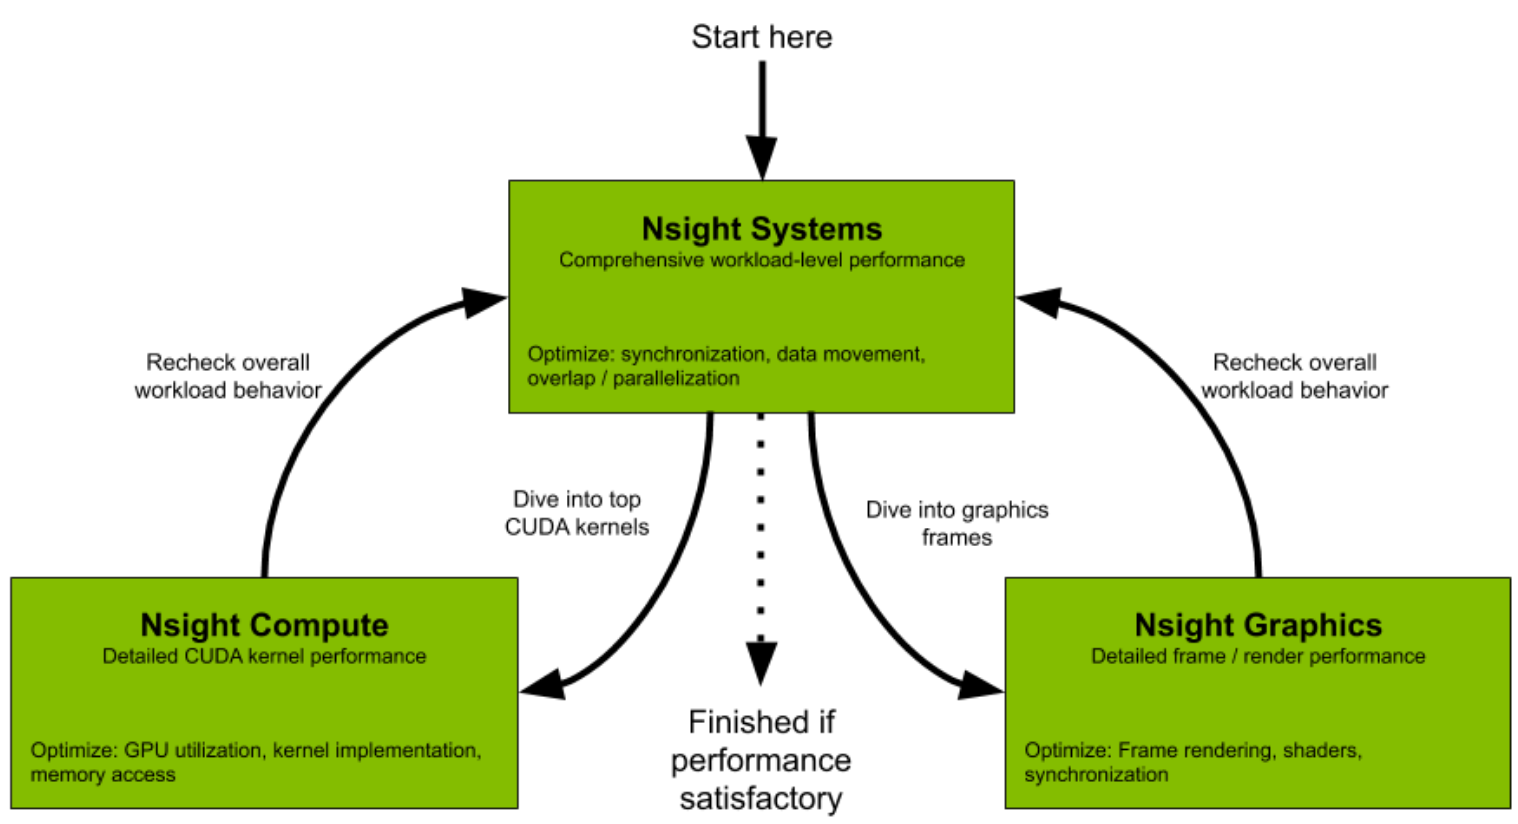

## NVIDIA Nsight Systems

The first NSight tool you should probably use to profile a GPU application, is NSight Systems. This tool gives an application-level overview, including a handy timeline, quickly visualizing times during execution where the GPU is underutilized and which operations are to blame for that.

The tool has two modes of operation:
- profile: run an application and profile at the end
- launch: launch an application for interactive profiling

There is also two ways of running the profiler:
- using the `nsys` binary on one end, and `nsys-ui` to visualize the result
- using `nsys-ui` to set-up and launch `nsys` automatically

NSight Systems can be freely downloaded and installed from the NVIDIA developer website. Once you've installed the tool, launch Julia under NSight Systems using `nsys launch julia`. If this reports `command ignored`, you're probably already running an NSight Systems session, and there can only be a single active session.

In [14]:
using CUDA

A = CUDA.rand(Float32, 1024, 1024);
B = CUDA.rand(Float32, 1024, 1024);

# warmup
A * B

# profile execution
CUDA.@profile CUDA.@sync A * B;

┌ Warning: Calling CUDA.@profile only informs an external profiler to start.
│ The user is responsible for launching Julia under a CUDA profiler.
│ 
│ It is recommended to use Nsight Systems, which supports interactive profiling:
│ $ nsys launch julia
└ @ CUDA.Profile /home/tim/Julia/depot/packages/CUDA/rZxom/lib/cudadrv/profile.jl:71


```
[ Info: Running under Nsight Systems, CUDA.@profile will automatically start the profiler

WARNING: CUDA tracing is required for cudaProfilerStart/Stop API support. Turning it on by default.
waiting for capture range to start the collection
Capture range started in the application
Capture range ended in the application
Processing events...
Saving temporary "/tmp/nsys-report-16b1-96f1-9095-b9f1.qdstrm" file to disk...

Creating final output files...
Processing [===============================================================100%]
Saved report file to "/tmp/nsys-report-16b1-96f1-9095-b9f1.nsys-rep"
Report file moved to "/scratch/snx3000/class99/report1.nsys-rep"

command ignored
[ Info: Profiling has finished, open the report listed above with `nsight-sys`
```

This will result in a `nsys-rep` file written to the current directory. You can then open this report using `nsys-ui`. Zoom in to see the kernel invocation:

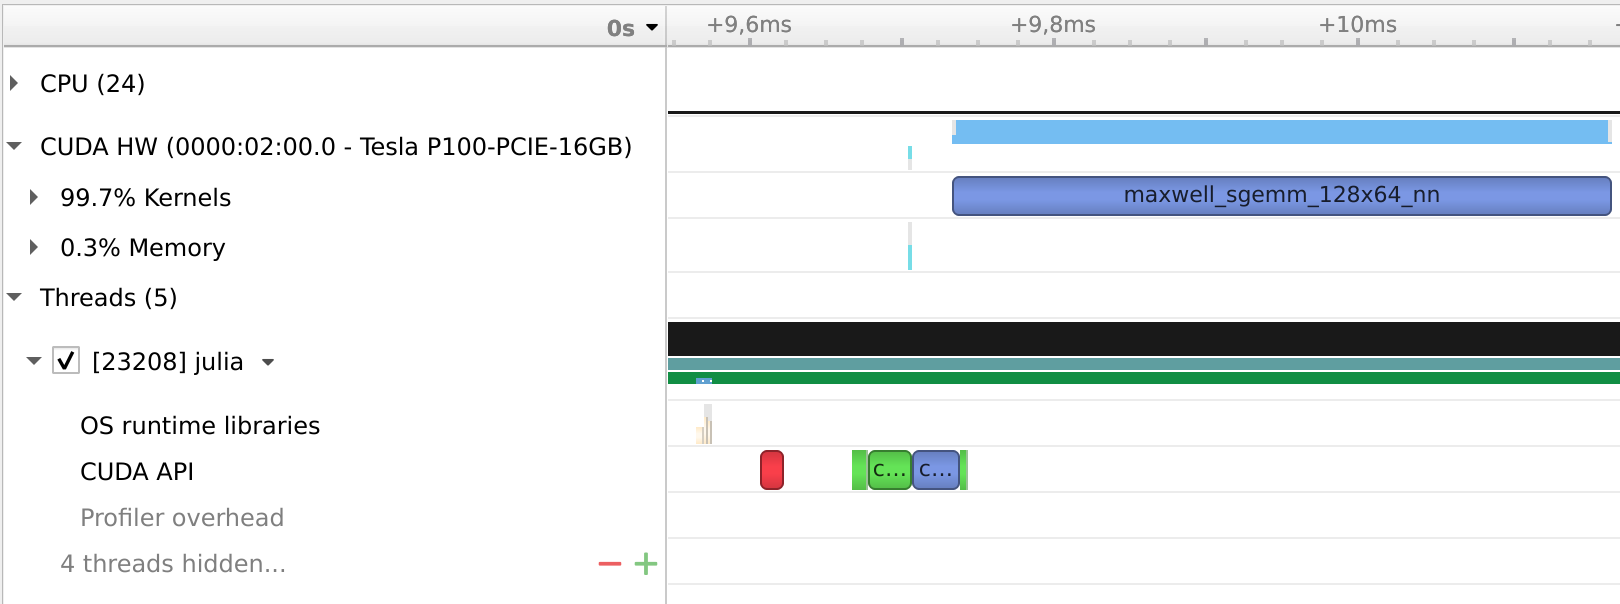

It's also possible to run Jupyter under NSight Systems, by adapting and adding the following kernel definition to `.local/share/jupyter/kernels`:

```
{
  "display_name": "Julia 1.7 (under NSight Systems)",
  "argv": [
    "/usr/local/bin/nsys",
    "launch",
    "/home/tim/.cache/jl/installs/bin/linux/x64/1.7/julia-1.7-latest-linux-x86_64/bin/julia",
    "-i",
    "--color=yes",
    "--project=@.",
    "/home/tim/Julia/depot/packages/IJulia/e8kqU/src/kernel.jl",
    "{connection_file}"
  ],
  "language": "julia",
  "env": {},
  "interrupt_mode": "signal"
}
```

I will do so for the remainder of this notebook, so let's re-import some packages:

In [15]:
using CUDA
using BenchmarkTools

### NVIDIA Tools Extensions

To accurately measure the total time it takes to execute this operation, you can use the mouse to measure on the timeline. A better approach is to denote the operation in source code, using NVIDIA's Tools Extensions (NVTX) library. This will then be picked up by NSight Systems, and added to the timeline:

In [16]:
A = CUDA.rand(Float32, 1024, 1024)
B = CUDA.rand(Float32, 1024, 1024)
CUDA.@profile NVTX.@range "mul!" CUDA.@sync A * B;

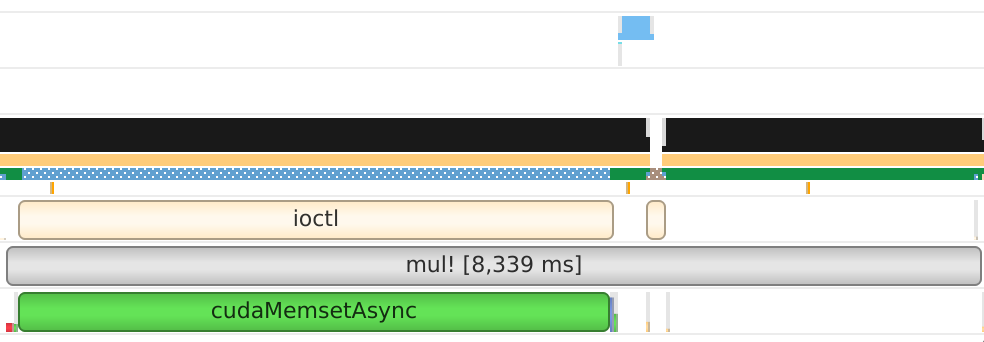

Note how our NVTX range nicely includes the time it took to queue the operation, as well as the execution on the GPU. This requires the NVTX range to include a synchronization!

The initial API call here is suspiciously slow though. This is a common occurence, and therefore it's recommended to profile any short-running application twice:

In [17]:
CUDA.@profile begin
    NVTX.@range "mul! 1" CUDA.@sync A * B
    NVTX.@range "mul! 2" CUDA.@sync A * B
end;

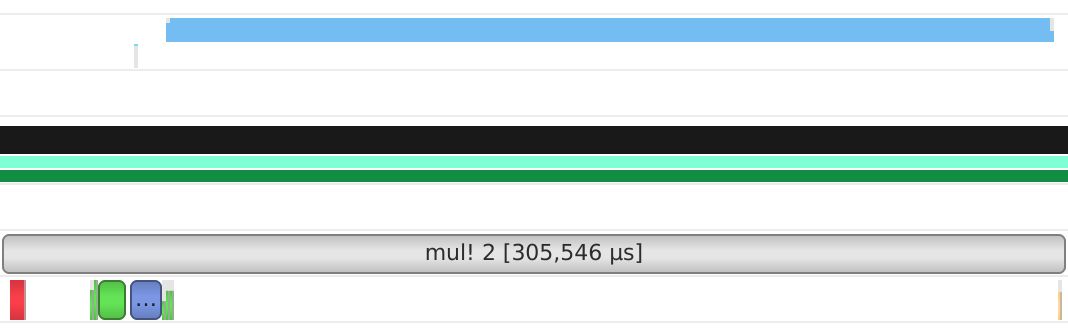

That's better, and much closer to our earlier benchmark results. Notice that it is still slightly slower, and some overhead is to be expected when running under the profiler.

NVTX can also be used to add markers to the source code:

In [18]:
CUDA.@profile begin
    NVTX.@range "mul! 1" CUDA.@sync A * B
    NVTX.@range "mul! 2" CUDA.@sync A * B
    NVTX.mark("done")
end;

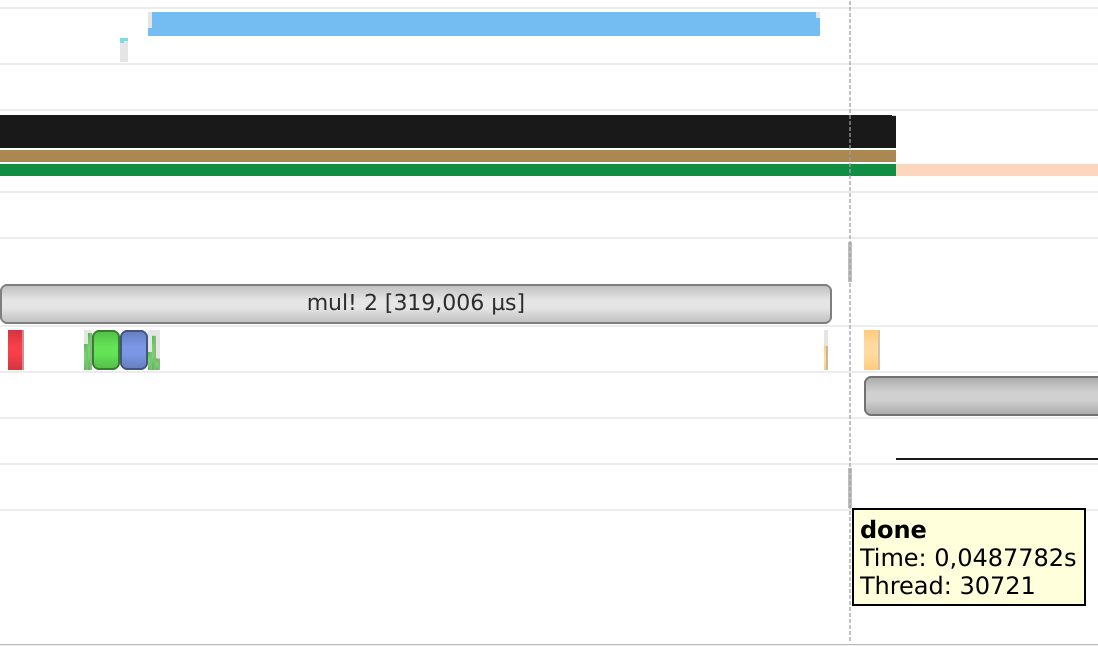

For details on the kernel's execution, expand the `GPU` part of the timeline and hover the kernel in question:

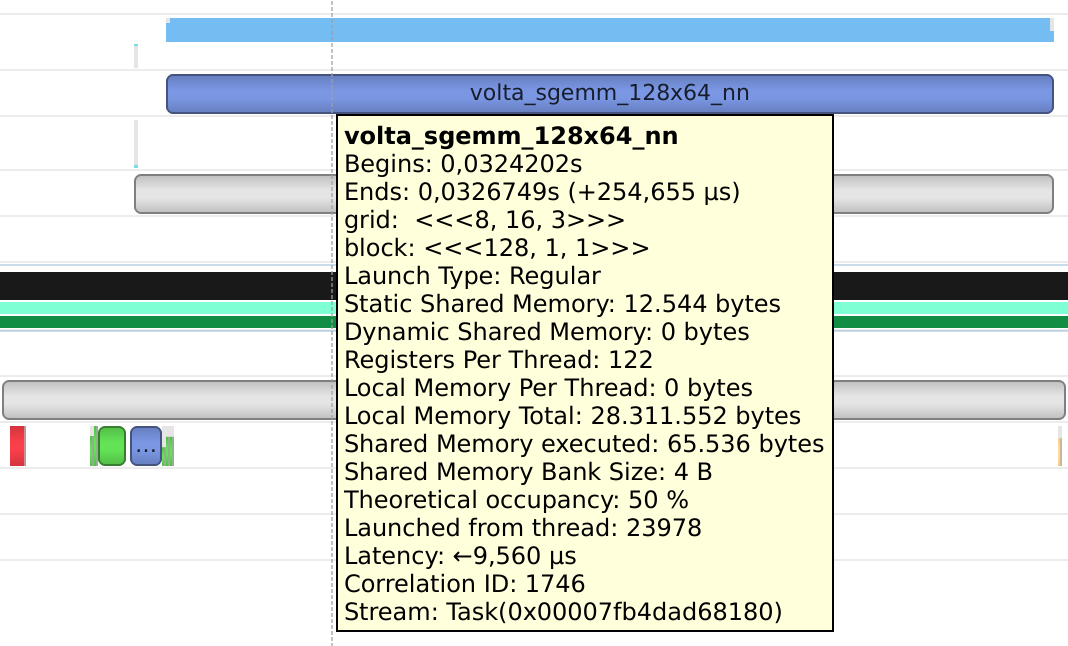

That gives some useful information on the kernel, but generally, there's more low-hanging fruit at the application level rather than at individual kernels.

## Case study: Batched RMSE

As a case study, let's look our implementation of a batched RMSE:

In [19]:
N = 16
A = CUDA.rand(1024, 1024, N)
B = CUDA.rand(1024, 1024, N)
CUDA.allowscalar(false)

In [20]:
NVTX.@range function rmse(A::AbstractMatrix, B::AbstractMatrix)
    sqrt(sum((A-B).^2)/length(A))
end

NVTX.@range function doit()
    rmses = Vector{eltype(A)}(undef, N)
    for i in 1:N
        rmses[i] = rmse(A[:, :, i], B[:, :, i])
    end
    rmses
end

doit()

16-element Vector{Float32}:
 0.40821013
 0.40828386
 0.40806293
 0.40812957
 0.40843484
 0.408638
 0.4082679
 0.40820947
 0.40873942
 0.40817377
 0.4080035
 0.40838856
 0.40841016
 0.408148
 0.40807354
 0.40822566

<div class="alert alert-block alert-info">
    <strong>Note</strong>: I'm purposefully keeping the actual RMSE operation as something that happens inside of a loop, to emulate an application that performs a bunch of operations in sequence. I'll show at the end of this notebook that it's possible to fuse operations across the loop's iterations.
</div>

In [21]:
@benchmark doit()

BenchmarkTools.Trial: 547 samples with 1 evaluation.
 Range (min … max):  3.368 ms … 289.867 ms  ┊ GC (min … max): 0.00% … 1.05%
 Time  (median):     3.846 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.140 ms ±  38.190 ms  ┊ GC (mean ± σ):  0.55% ± 0.13%

  █                                                            
  █▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▆
  3.37 ms      Histogram: log(frequency) by time       289 ms <

 Memory estimate: 175.42 KiB, allocs estimate: 3602.

<div class="alert alert-info">
    <strong>Note</strong>: Explicit synchronization is not required here, since we fetch the GPU memory by calling the `Array` function which requires the GPU to be idle.
</div>

To determine whether we're using the GPU efficiently, let's look at a timeline:

In [22]:
CUDA.@profile (doit(); doit());

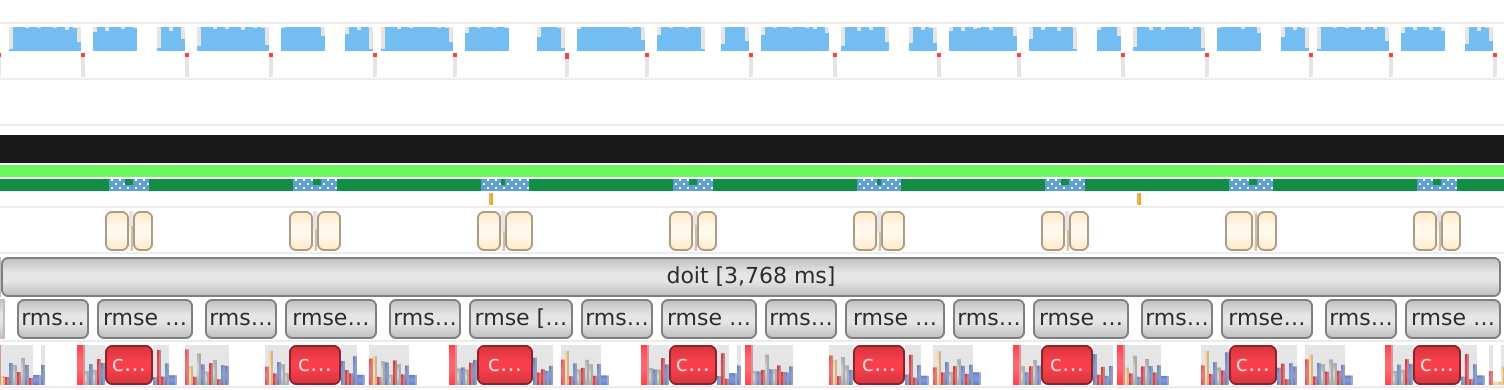

What we're generally looking for, is a continuous stream of kernels that keeps the GPU busy. That's not the case here, as there's lots of white space between blocks of kernels indicating the GPU is essentially idle at that time. This is generally caused by the CPU not being able to queue work quickly enough, so we need to avoid needless operations (memory allocations, copies, or just CPU operations in general) between launching subsequent kernels.

At the same time, we're launching many different kernels, which has several disadvantages:
- temporaries need to be allocated to pass data between kernels
- each kernel needs to read from global memory to fetch those temporaries
- the compiler can't optimize 'globally'

With these general guidelines in mind, try to use the tools we've explained here (NSight Systems, BenchmarkTools) to analyze and optimize this operation. Focus on optimizing the application from the high level, we'll separately deal with optimizing a kernel in the next notebook.

### Avoid unnecessary allocations and copies

There's some time being wasted before every invocation of the `rmse` function:

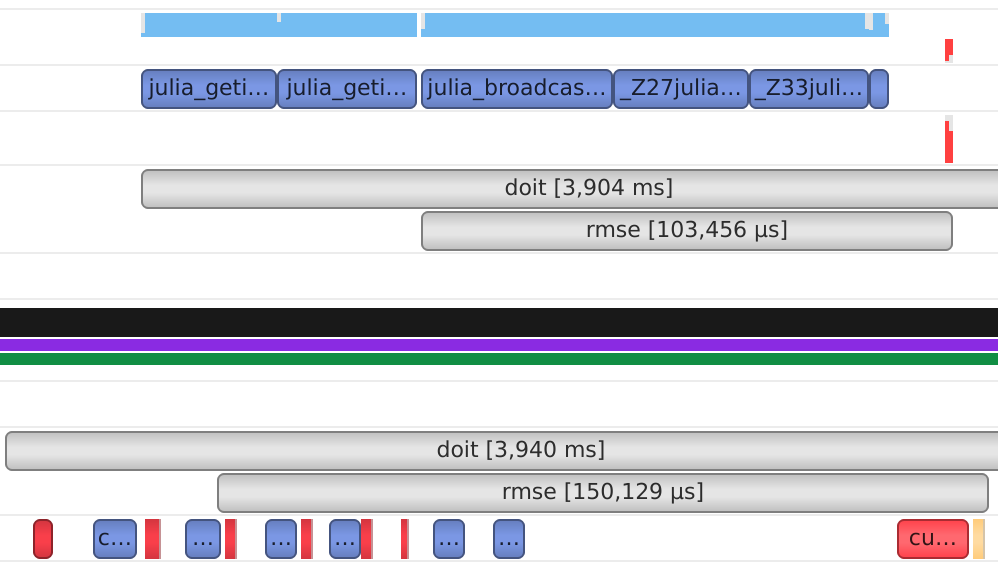

The cause for the overhead is the slicing of arrays, which copies data! Let's convert it into a view instead:

In [23]:
NVTX.@range function doit()
    rmses = Vector{eltype(A)}(undef, N)
    for i in 1:N
        rmses[i] = rmse(view(A, :, :, i), view(B, :, :, i))
    end
    rmses
end

doit()

16-element Vector{Float32}:
 0.40821013
 0.40828386
 0.40806293
 0.40812957
 0.40843484
 0.408638
 0.4082679
 0.40820947
 0.40873942
 0.40817377
 0.4080035
 0.40838856
 0.40841016
 0.408148
 0.40807354
 0.40822566

In [24]:
@benchmark doit()

BenchmarkTools.Trial: 984 samples with 1 evaluation.
 Range (min … max):  2.012 ms … 291.870 ms  ┊ GC (min … max): 0.00% … 1.27%
 Time  (median):     2.080 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.077 ms ±  28.238 ms  ┊ GC (mean ± σ):  0.67% ± 0.12%

   ▆█▅       ▄▄▂   ▂▁ ▁   ▁ ▁                                  
  ▆████▅▄▄▁▄▅███▇█▄██▇█▇█▇█████▇▆▅▇▅█▇▆▅▆▄▅▄▁▄▅▅▅▁▅▄▄▄▁▁▁▁▁▁▄ █
  2.01 ms      Histogram: log(frequency) by time      3.25 ms <

 Memory estimate: 136.42 KiB, allocs estimate: 2418.

In [25]:
CUDA.@profile (doit(); doit());

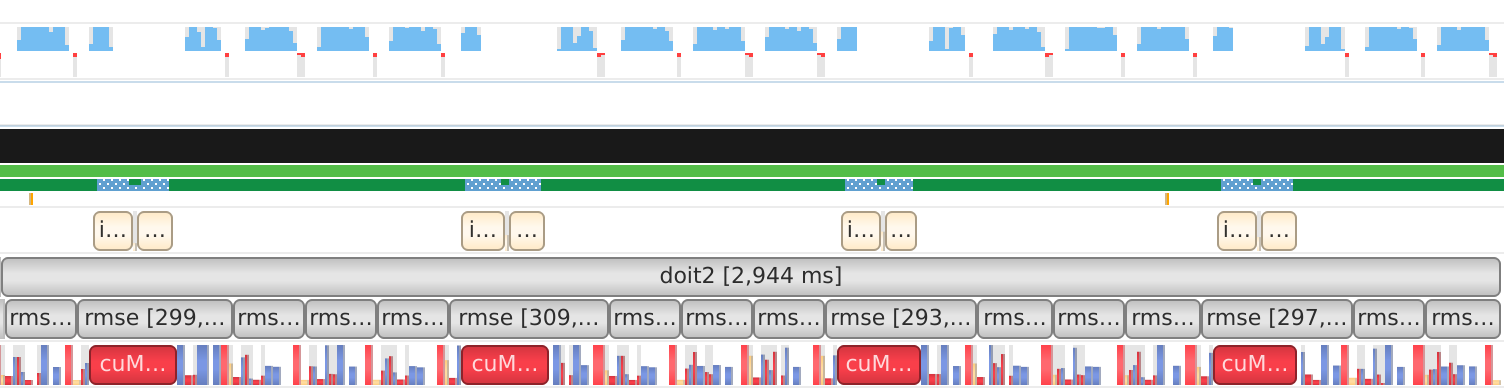

The invocations of the `rmse` function are now closely packed together, but the GPU trace itself is still very sparse. There are several reasons for this:

- lots of kernels are being launched: this takes time, and requires temporary allocations
- each iteration waits for the GPU to finish, as we compute a scalar sum

### Avoid synchronization

A good first trick is to always reduce to an array, which doesn't need to be available immediately:

In [26]:
NVTX.@range function rmse(A::AbstractMatrix, B::AbstractMatrix)
    sqrt.(sum((A-B).^2; dims=(1,2))./length(A))
end

NVTX.@range function doit()
    rmses = Vector(undef, N)
    for i in 1:N
        rmses[i] = rmse(view(A, :, :, i), view(B, :, :, i))
    end
    vcat(Array.(rmses)...)
end

doit()

16×1 Matrix{Float32}:
 0.40821013
 0.40828386
 0.4080629
 0.40812957
 0.4084348
 0.40863797
 0.4082679
 0.40820947
 0.4087394
 0.40817377
 0.4080035
 0.40838856
 0.40841016
 0.408148
 0.40807354
 0.40822563

In [27]:
@benchmark doit()

BenchmarkTools.Trial: 1119 samples with 1 evaluation.
 Range (min … max):  1.524 ms … 295.325 ms  ┊ GC (min … max): 0.00% … 1.85%
 Time  (median):     1.654 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.682 ms ±  28.794 ms  ┊ GC (mean ± σ):  1.10% ± 0.18%

  █                                                            
  █▅▄▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▂
  1.52 ms         Histogram: frequency by time        18.5 ms <

 Memory estimate: 267.73 KiB, allocs estimate: 4330.

In [28]:
CUDA.@profile (doit(); doit());

With all synchronizing operations now happening at the end, most of the gaps between GPU operations have disappeared:

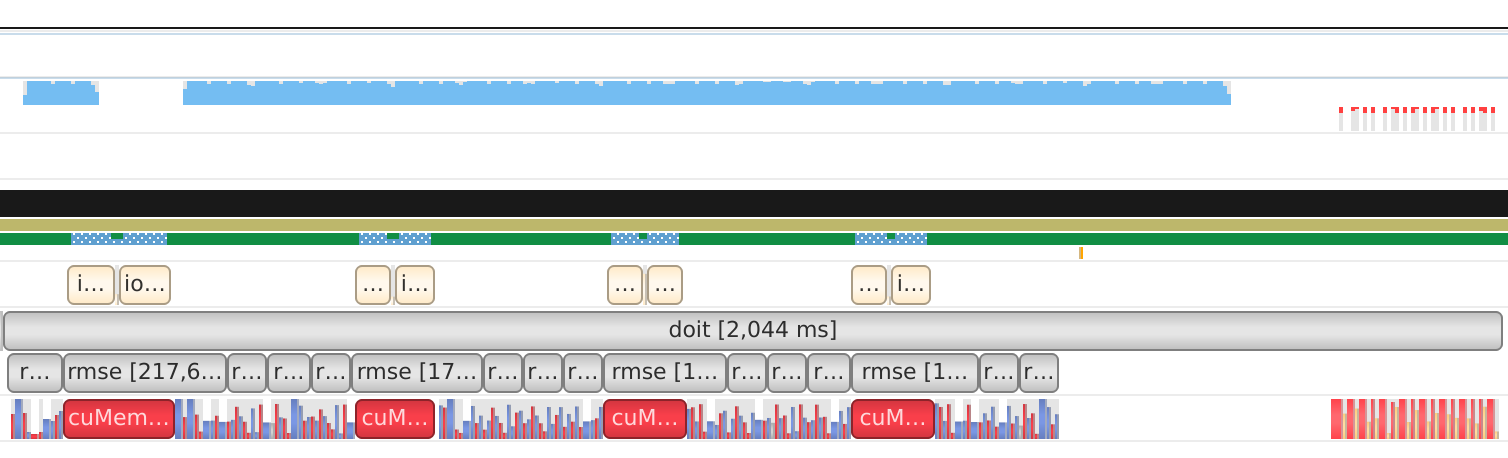

However, there are still many allocations left, some taking up quite some time. So a logical next step is to pre-allocate those outputs, and have `sum!` reduce into that:

In [29]:
NVTX.@range function rmse(A::AbstractMatrix, B::AbstractMatrix, C::AbstractMatrix)
    sum!(C, (A-B).^2)
    C .= sqrt.(C./length(A))
    return
end

NVTX.@range function doit()
    rmses = similar(A, N)
    for i in 1:N
        rmse(view(A, :, :, i), view(B, :, :, i), reshape(view(rmses, i), 1, 1))
    end
    Array(rmses)
end

doit()

16-element Vector{Float32}:
 0.40821013
 0.40828386
 0.4080629
 0.40812957
 0.4084348
 0.40863797
 0.4082679
 0.40820947
 0.4087394
 0.40817377
 0.4080035
 0.40838856
 0.40841016
 0.408148
 0.40807354
 0.40822563

In [30]:
@benchmark doit()

BenchmarkTools.Trial: 1119 samples with 1 evaluation.
 Range (min … max):  1.473 ms … 302.271 ms  ┊ GC (min … max): 0.00% … 1.55%
 Time  (median):     1.605 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.548 ms ±  28.607 ms  ┊ GC (mean ± σ):  0.94% ± 0.15%

  █                                                            
  █▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▂
  1.47 ms         Histogram: frequency by time        24.3 ms <

 Memory estimate: 171.84 KiB, allocs estimate: 2904.

In [31]:
CUDA.@profile (doit(); doit());

We are now performing way fewer memory operations, both at every iteration and at the end of the execution:

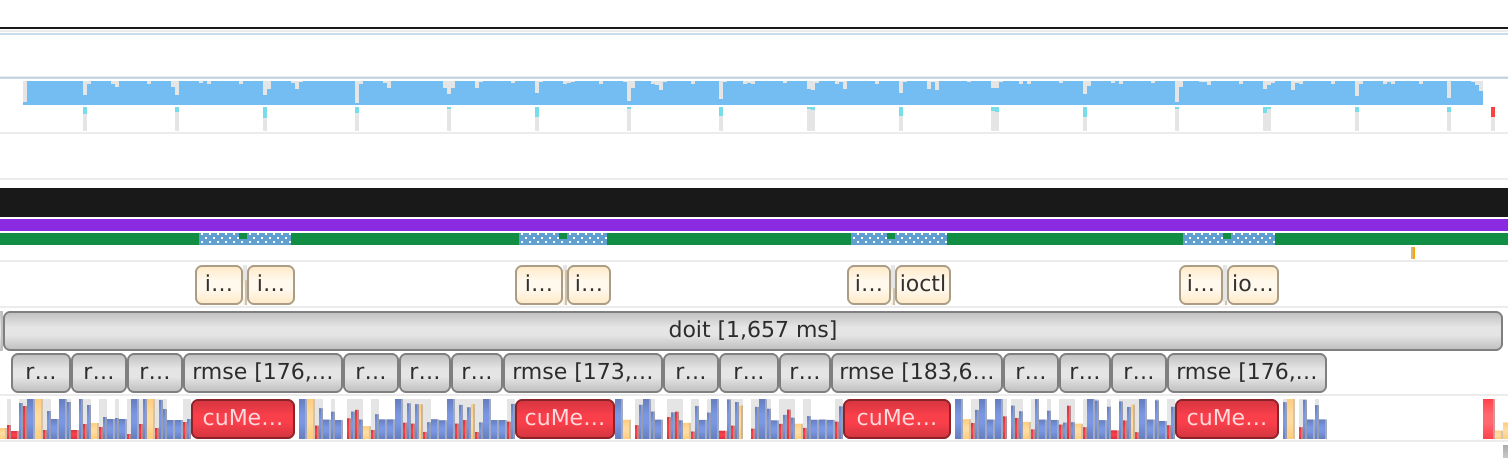

But, at every iteration we still allocate some memory, and launch a bunch of kernels. Fusing those together is both going to improve performance, and avoid the allocation of temporaries.

### Fuse operations into the reduction

To reduce the amount of kernels, we can use `mapreducedim!` instead of `sum!` so that we can pass additional functions:

In [32]:
NVTX.@range function rmse(A::AbstractMatrix, B::AbstractMatrix, C::AbstractMatrix)
    Base.mapreducedim!((a,b)->(a-b)^2, +, C, A, B)
    C .= sqrt.(C./length(A))
    return
end

NVTX.@range function doit()
    rmses = similar(A, N)
    fill!(rmses, zero(eltype(A)))
    for i in 1:N
        rmse(view(A, :, :, i), view(B, :, :, i), reshape(view(rmses, i), 1, 1))
    end
    Array(rmses)
end

doit()

LoadError: MethodError: no method matching mapreducedim!(::var"#2#3", ::typeof(+), ::CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}, ::CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}, ::CuArray{Float32, 2, CUDA.Mem.DeviceBuffer})
[0mClosest candidates are:
[0m  mapreducedim!(::Any, ::Any, ::Union{GPUArrays.AbstractGPUArray{T, N}, Base.LogicalIndex{T, var"#s5"} where var"#s5"<:GPUArrays.AbstractGPUArray, Base.ReinterpretArray{T, N, var"#s1", var"#s2", IsReshaped} where {var"#s13"<:GPUArrays.AbstractGPUArray, var"#s1", var"#s2"<:Union{SubArray{var"#s3", var"#s4", var"#s13", I, L} where {var"#s3", var"#s4", I, L}, var"#s13"}, IsReshaped}, Base.ReshapedArray{T, N, var"#s4", MI} where {var"#s14"<:GPUArrays.AbstractGPUArray, var"#s4"<:Union{Base.ReinterpretArray{var"#s1", var"#s5", var"#s11", var"#s2", IsReshaped} where {var"#s1", var"#s5", var"#s11", var"#s2"<:Union{SubArray{var"#s3", var"#s4", var"#s14", I, L} where {var"#s3", var"#s4", I, L}, var"#s14"}, IsReshaped}, SubArray{var"#s3", var"#s2", var"#s14", I, L} where {var"#s3", var"#s2", I, L}, var"#s14"}, MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64}, N} where N}}, SubArray{T, N, var"#s5", I, L} where {var"#s15"<:GPUArrays.AbstractGPUArray, var"#s5"<:Union{Base.ReinterpretArray{var"#s2", var"#s1", var"#s11", var"#s21", IsReshaped} where {var"#s2", var"#s1", var"#s11", var"#s21"<:Union{SubArray{var"#s3", var"#s4", var"#s15", I, L} where {var"#s3", var"#s4", I, L}, var"#s15"}, IsReshaped}, Base.ReshapedArray{var"#s4", var"#s3", var"#s41", MI} where {var"#s4", var"#s3", var"#s41"<:Union{Base.ReinterpretArray{var"#s1", var"#s5", var"#s11", var"#s2", IsReshaped} where {var"#s1", var"#s5", var"#s11", var"#s2"<:Union{SubArray{var"#s3", var"#s4", var"#s15", I, L} where {var"#s3", var"#s4", I, L}, var"#s15"}, IsReshaped}, SubArray{var"#s3", var"#s2", var"#s15", I, L} where {var"#s3", var"#s2", I, L}, var"#s15"}, MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64}, N} where N}}, var"#s15"}, I, L}, LinearAlgebra.Adjoint{T, var"#s1"} where var"#s1"<:GPUArrays.AbstractGPUArray{T, N}, LinearAlgebra.Diagonal{T, var"#s11"} where var"#s11"<:GPUArrays.AbstractGPUArray{T, N}, LinearAlgebra.LowerTriangular{T, var"#s7"} where var"#s7"<:GPUArrays.AbstractGPUArray{T, N}, LinearAlgebra.Transpose{T, var"#s6"} where var"#s6"<:GPUArrays.AbstractGPUArray{T, N}, LinearAlgebra.Tridiagonal{T, var"#s12"} where var"#s12"<:GPUArrays.AbstractGPUArray{T, N}, LinearAlgebra.UnitLowerTriangular{T, var"#s8"} where var"#s8"<:GPUArrays.AbstractGPUArray{T, N}, LinearAlgebra.UnitUpperTriangular{T, var"#s10"} where var"#s10"<:GPUArrays.AbstractGPUArray{T, N}, LinearAlgebra.UpperTriangular{T, var"#s9"} where var"#s9"<:GPUArrays.AbstractGPUArray{T, N}, PermutedDimsArray{T, N, var"#s4", var"#s3", var"#s2"} where {var"#s4", var"#s3", var"#s2"<:GPUArrays.AbstractGPUArray}} where {T, N}, ::AbstractArray) at /home/tim/Julia/depot/packages/GPUArrays/3sW6s/src/host/mapreduce.jl:10
[0m  mapreducedim!(::Any, ::Any, ::AbstractArray, ::Union{Base.AbstractBroadcasted, AbstractArray}) at reducedim.jl:277
[0m  mapreducedim!(::Any, ::Any, ::Union{GPUArrays.AbstractGPUArray{T, N}, Base.LogicalIndex{T, var"#s5"} where var"#s5"<:GPUArrays.AbstractGPUArray, Base.ReinterpretArray{T, N, var"#s1", var"#s2", IsReshaped} where {var"#s13"<:GPUArrays.AbstractGPUArray, var"#s1", var"#s2"<:Union{SubArray{var"#s3", var"#s4", var"#s13", I, L} where {var"#s3", var"#s4", I, L}, var"#s13"}, IsReshaped}, Base.ReshapedArray{T, N, var"#s4", MI} where {var"#s14"<:GPUArrays.AbstractGPUArray, var"#s4"<:Union{Base.ReinterpretArray{var"#s1", var"#s5", var"#s11", var"#s2", IsReshaped} where {var"#s1", var"#s5", var"#s11", var"#s2"<:Union{SubArray{var"#s3", var"#s4", var"#s14", I, L} where {var"#s3", var"#s4", I, L}, var"#s14"}, IsReshaped}, SubArray{var"#s3", var"#s2", var"#s14", I, L} where {var"#s3", var"#s2", I, L}, var"#s14"}, MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64}, N} where N}}, SubArray{T, N, var"#s5", I, L} where {var"#s15"<:GPUArrays.AbstractGPUArray, var"#s5"<:Union{Base.ReinterpretArray{var"#s2", var"#s1", var"#s11", var"#s21", IsReshaped} where {var"#s2", var"#s1", var"#s11", var"#s21"<:Union{SubArray{var"#s3", var"#s4", var"#s15", I, L} where {var"#s3", var"#s4", I, L}, var"#s15"}, IsReshaped}, Base.ReshapedArray{var"#s4", var"#s3", var"#s41", MI} where {var"#s4", var"#s3", var"#s41"<:Union{Base.ReinterpretArray{var"#s1", var"#s5", var"#s11", var"#s2", IsReshaped} where {var"#s1", var"#s5", var"#s11", var"#s2"<:Union{SubArray{var"#s3", var"#s4", var"#s15", I, L} where {var"#s3", var"#s4", I, L}, var"#s15"}, IsReshaped}, SubArray{var"#s3", var"#s2", var"#s15", I, L} where {var"#s3", var"#s2", I, L}, var"#s15"}, MI<:Tuple{Vararg{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64}, N} where N}}, var"#s15"}, I, L}, LinearAlgebra.Adjoint{T, var"#s1"} where var"#s1"<:GPUArrays.AbstractGPUArray{T, N}, LinearAlgebra.Diagonal{T, var"#s11"} where var"#s11"<:GPUArrays.AbstractGPUArray{T, N}, LinearAlgebra.LowerTriangular{T, var"#s7"} where var"#s7"<:GPUArrays.AbstractGPUArray{T, N}, LinearAlgebra.Transpose{T, var"#s6"} where var"#s6"<:GPUArrays.AbstractGPUArray{T, N}, LinearAlgebra.Tridiagonal{T, var"#s12"} where var"#s12"<:GPUArrays.AbstractGPUArray{T, N}, LinearAlgebra.UnitLowerTriangular{T, var"#s8"} where var"#s8"<:GPUArrays.AbstractGPUArray{T, N}, LinearAlgebra.UnitUpperTriangular{T, var"#s10"} where var"#s10"<:GPUArrays.AbstractGPUArray{T, N}, LinearAlgebra.UpperTriangular{T, var"#s9"} where var"#s9"<:GPUArrays.AbstractGPUArray{T, N}, PermutedDimsArray{T, N, var"#s4", var"#s3", var"#s2"} where {var"#s4", var"#s3", var"#s2"<:GPUArrays.AbstractGPUArray}} where {T, N}, [91m::Base.Broadcast.Broadcasted[39m) at /home/tim/Julia/depot/packages/GPUArrays/3sW6s/src/host/mapreduce.jl:11

Sadly, Base's `mapreducedim!` doesn't currently support multiple input array arguments (while `mapreduce` does, but allocates), so let's manually expand that broadcast:

In [33]:
NVTX.@range function rmse(A::AbstractMatrix, B::AbstractMatrix, C::AbstractMatrix)
    SQE = Broadcast.broadcasted(A, B) do a,b
        (a - b) ^ 2
    end
    SQE = Broadcast.instantiate(SQE)
    Base.mapreducedim!(identity, +, C, SQE)
    C .= sqrt.(C./length(A))
    return
end

NVTX.@range function doit()
    rmses = similar(A, N)
    fill!(rmses, zero(eltype(A)))
    for i in 1:N
        rmse(view(A, :, :, i), view(B, :, :, i), reshape(view(rmses, i), 1, 1))
    end
    Array(rmses)
end

doit()

16-element Vector{Float32}:
 0.40821013
 0.40828386
 0.4080629
 0.40812957
 0.4084348
 0.40863797
 0.4082679
 0.40820947
 0.4087394
 0.40817377
 0.4080035
 0.40838856
 0.40841016
 0.408148
 0.40807354
 0.40822563

<div class="alert alert-block alert-warning">
    <strong>Warning</strong>: <code>mapreducedim!</code> requires the output to be properly initialized.
</div>

In [34]:
@benchmark doit()

BenchmarkTools.Trial: 6764 samples with 1 evaluation.
 Range (min … max):  617.473 μs …  21.565 ms  ┊ GC (min … max): 0.00% … 46.44%
 Time  (median):     662.607 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   735.595 μs ± 965.034 μs  ┊ GC (mean ± σ):  3.34% ±  2.47%

  ▁▁▂▂ ▄█▅▁ ▂▃                 ▂                      ▁▁        ▁
  █████████████▅▆▄▅▅▅▁▅▄▄▁▄▅▁▄██▇▅▅▃▄▄▆▄▄▁▃▅▁▅▅▆▃▄▄▃▃████▇▇▁▅▅▆ █
  617 μs        Histogram: log(frequency) by time       1.03 ms <

 Memory estimate: 117.59 KiB, allocs estimate: 1992.

In [35]:
CUDA.@profile (doit(); doit());

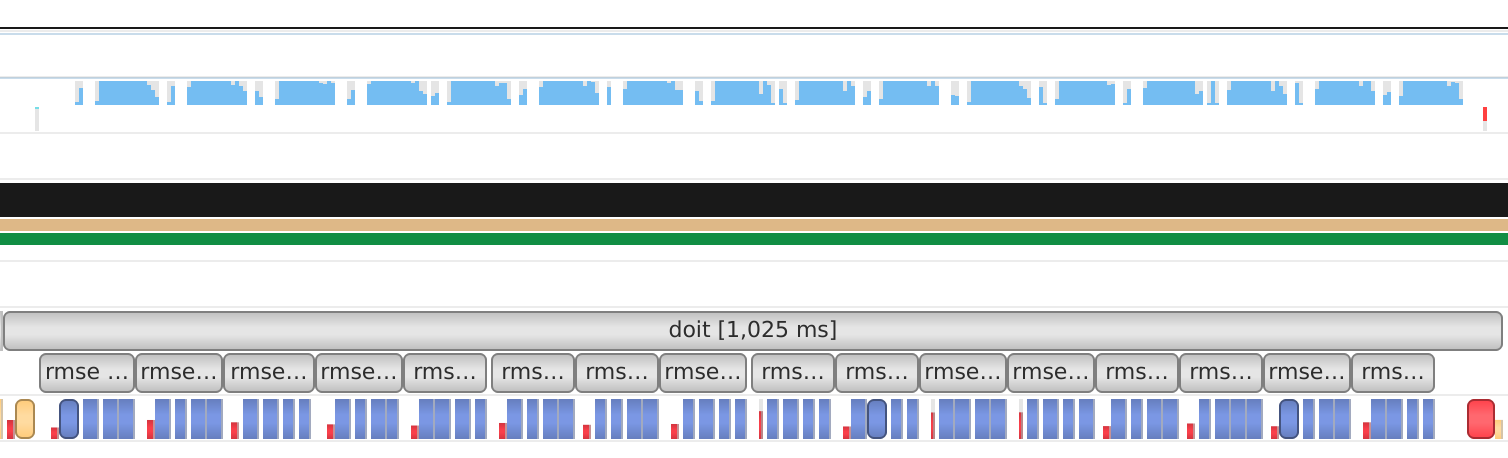

### Fuse operations across the outer loop

Of course, this entire exercise is slightly contrived, and we could have started out by getting rid of the `for` loop and using array operations across the batch dimension:

In [36]:
NVTX.@range function rmse(A::AbstractArray, B::AbstractArray, C::AbstractArray)
    SQE = Broadcast.broadcasted(A, B) do a,b
        (a - b) ^ 2
    end
    SQE = Broadcast.instantiate(SQE)
    Base.mapreducedim!(identity, +, C, SQE)
    C .= sqrt.(C ./ prod(size(A)[1:2]))
    return
end

NVTX.@range function doit()
    rmses = similar(A, 1, 1, N)
    fill!(rmses, zero(eltype(A)))
    rmse(A, B, rmses)
    Array(rmses)
end

doit()

1×1×16 Array{Float32, 3}:
[:, :, 1] =
 0.40821016

[:, :, 2] =
 0.40828386

[:, :, 3] =
 0.4080629

...

[:, :, 14] =
 0.40814802

[:, :, 15] =
 0.40807354

[:, :, 16] =
 0.40822563

In [37]:
@benchmark doit()

BenchmarkTools.Trial: 8357 samples with 1 evaluation.
 Range (min … max):  541.664 μs …  25.427 ms  ┊ GC (min … max): 0.00% … 40.68%
 Time  (median):     566.174 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   593.137 μs ± 315.220 μs  ┊ GC (mean ± σ):  0.21% ±  0.45%

  ▃▇▇█▇▅▅▄▂▂▂              ▂▂                            ▁      ▂
  ████████████▅▆▅▃▁▁▄▃▄▄▃▆███▇▆▅▄▅▇▆▃▄▁▃▃▁▅▅▅▅▆▆▅▁▅▆▆▅▇█████▇▇▇ █
  542 μs        Histogram: log(frequency) by time        948 μs <

 Memory estimate: 8.70 KiB, allocs estimate: 134.

In [38]:
CUDA.@profile (doit(); doit());

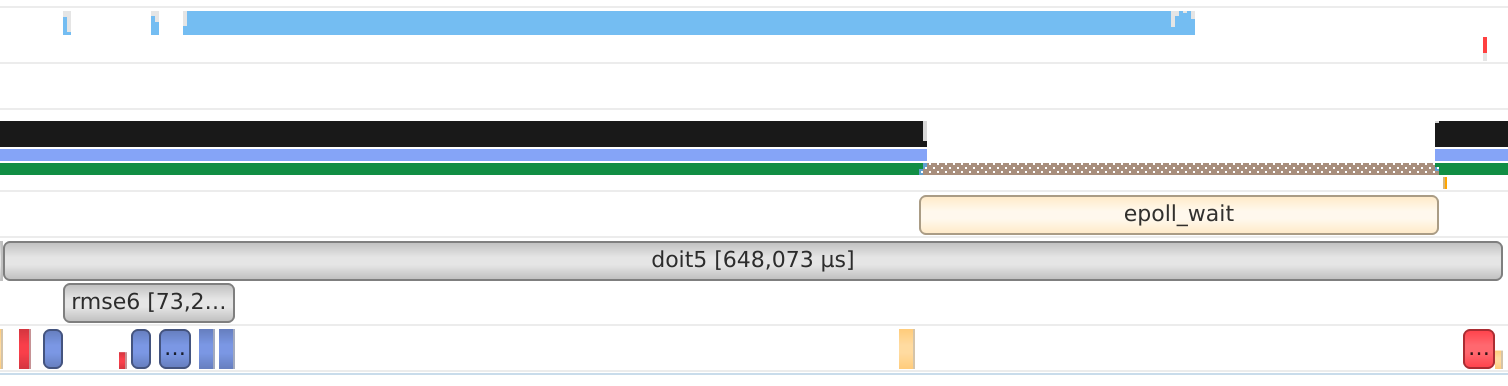

By getting rid of the loop, we only need to launch a single series of kernels, so the effects of using unfused kernels would have been less pronounced. Still, the individual optimizations were worth it, even when processing all batches at once.

Summarized, when optimizing a GPU application it's good to:

- fuse operations: avoids temporaries, reduces launch overhead, and enables global optimization
- avoid synchronization: either explicit, or implicit (e.g. using pinned memory)
- bundle memory operations: pre-allocation, fetch results at the end

Many of these optimization can be implemented generically, i.e., without introducing GPU-specific operations (e.g. avoiding calls to constructors but use `similar`, ...). As a result, it's still possible to use the above functions with CPU arrays, even with the NVTX annotations still attached to them:

In [39]:
A = rand(Float32, 1024, 1024, N)
B = rand(Float32, 1024, 1024, N)

# sadly, Base's mapreducedim! doesn't support Broadcasted inputs,
# so we eagerly lower it
NVTX.@range function rmse(A::AbstractArray, B::AbstractArray, C::AbstractArray)
    SQE = (A .- B) .^ 2
    Base.mapreducedim!(identity, +, C, SQE)
    C .= sqrt.(C ./ prod(size(A)[1:2]))
    return
end

NVTX.@range function doit()
    rmses = similar(A, 1, 1, N)
    fill!(rmses, zero(eltype(A)))
    rmse(A, B, rmses)
    Array(rmses)
end

doit()

1×1×16 Array{Float32, 3}:
[:, :, 1] =
 0.40807673

[:, :, 2] =
 0.40847325

[:, :, 3] =
 0.40805596

...

[:, :, 14] =
 0.4080444

[:, :, 15] =
 0.40827692

[:, :, 16] =
 0.4085138

In [40]:
@benchmark doit()

BenchmarkTools.Trial: 262 samples with 1 evaluation.
 Range (min … max):  16.167 ms … 30.102 ms  ┊ GC (min … max):  0.00% … 26.99%
 Time  (median):     16.937 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   19.124 ms ±  3.170 ms  ┊ GC (mean ± σ):  10.05% ± 11.63%

  ▁▂▆█▅▁                             ▁▂▄▄▂                     
  ██████▆▁▇▄▄▁▁▁▁▁▁▄▁▁▁▁▄▁▄▇▁▁▄▁▄▁▁▄▇██████▄▄▄▄▁▁▁▁▁▄▄▁▁▁▁▁▁▄ ▆
  16.2 ms      Histogram: log(frequency) by time      26.9 ms <

 Memory estimate: 64.00 MiB, allocs estimate: 4.

### Bonus: Tullio.jl

Let's also have a look at the performance of Tullio:

In [48]:
using Tullio, KernelAbstractions, CUDAKernels

A = CUDA.rand(1024, 1024, N)
B = CUDA.rand(1024, 1024, N)

function doit_tullio()
    @tullio C[k] := (A[i,j,k] - B[i,j,k])^2 |> sqrt(_ / (size(A,1)*size(A,2)))
    Array(C)
end

doit_tullio()

16-element Vector{Float32}:
 0.40818393
 0.40784022
 0.40833566
 0.40797314
 0.40785512
 0.4077464
 0.4081234
 0.407791
 0.40824723
 0.40812263
 0.40822122
 0.4084038
 0.4078497
 0.40802178
 0.4076855
 0.40803334

In [49]:
@benchmark doit_tullio()

BenchmarkTools.Trial: 45 samples with 1 evaluation.
 Range (min … max):  109.054 ms … 116.149 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     111.907 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   112.071 ms ±   2.017 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

          ▁█       ▄    ▁ ▁▁      ▁  ▁    ▁         ▁            
  ▆▆▆▆▁▁▆▆██▆▆▆▁▁▁▁█▆▆▁▁█▁██▆▁▁▁▁▆█▁▁█▆▁▆▁█▁▁▆▁▁▁▆▆▆█▁▁▁▁▁▁▁▆▆▆ ▁
  109 ms           Histogram: frequency by time          116 ms <

 Memory estimate: 5.11 KiB, allocs estimate: 124.

That's pretty bad, and probably a bug since Tullio generally performs pretty well. For example, compared to the CPU implementation:

In [50]:
A = rand(Float32, 1024, 1024, N)
B = rand(Float32, 1024, 1024, N)
@benchmark doit_tullio()

BenchmarkTools.Trial: 1841 samples with 1 evaluation.
 Range (min … max):  2.289 ms …   3.939 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.690 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.705 ms ± 167.348 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                 ▂▁▁▃▂▅▅▆▆▄█▇█▅▄▄▂▄▁▂▁                         
  ▂▂▂▂▂▂▃▄▃▅▅▆▆████████████████████████▇▆██▆▅▄▄▄▃▃▄▄▃▃▁▂▃▂▂▃▂ ▅
  2.29 ms         Histogram: frequency by time        3.19 ms <

 Memory estimate: 13.06 KiB, allocs estimate: 279.

### Bonus: Computation graph

Instead of manually fusing operations, we could also have tried to use the CUDA Graph APIs. Let's start with the original version:

In [44]:
A = CUDA.rand(1024, 1024, N)
B = CUDA.rand(1024, 1024, N)
NVTX.@range function rmse(A::AbstractMatrix, B::AbstractMatrix)
    sqrt(sum((A-B).^2)/length(A))
end

NVTX.@range function doit()
    rmses = Vector{eltype(A)}(undef, N)
    for i in 1:N
        @captured rmses[i] = rmse(A[:, :, i], B[:, :, i])
    end
    rmses
end

doit()

LoadError: CUDA error: operation failed due to a previous error during capture (code 901, ERROR_STREAM_CAPTURE_INVALIDATED)

This may fail (depending on the CUDA toolkit and CUDA.jl version) because we're performing operations within the `@captured` body that are currently unsupported, either by CUDA or by CUDA.jl doing something CUDA doesn't like. The culprit here is the memory copies to and from GPU memory. Let's avoid these by making the operation in-place (but we still keep the unfused operations to demonstrate the value of the graph APIs):

In [45]:
NVTX.@range function rmse(A::AbstractMatrix, B::AbstractMatrix, C::AbstractMatrix)
    sum!(C, (A-B).^2)
    C .= sqrt.(C./length(A))
    return
end

NVTX.@range function doit()
    rmses = similar(A, N)
    for i in 1:N
        @captured rmse(view(A, :, :, i), view(B, :, :, i), reshape(view(rmses, i), 1, 1))
    end
    Array(rmses)
end

doit()

16-element Vector{Float32}:
 0.4081465
 0.40849438
 0.40831357
 0.40849328
 0.40819958
 0.4083572
 0.40826538
 0.4079879
 0.4083766
 0.4084265
 0.4081657
 0.40821758
 0.40838185
 0.40846515
 0.40820006
 0.40839794

<div class="alert alert-block alert-info">
    <strong>Note</strong>: There may be some errors in the output about freeing data, but those do not affect the correctness and are <a href="https://github.com/JuliaGPU/CUDA.jl/issues/1230">known issues</a> to be resolved in a future CUDA.jl release.
</div>

To compare performance, let's look at the profiler trace of the original function:

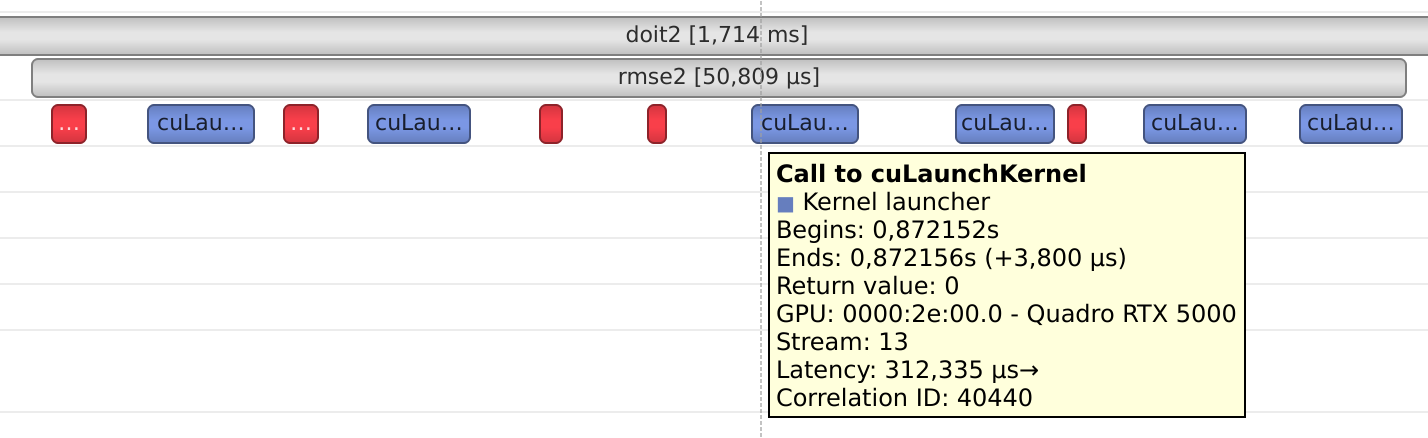

... and compare to the function using `@captured`:

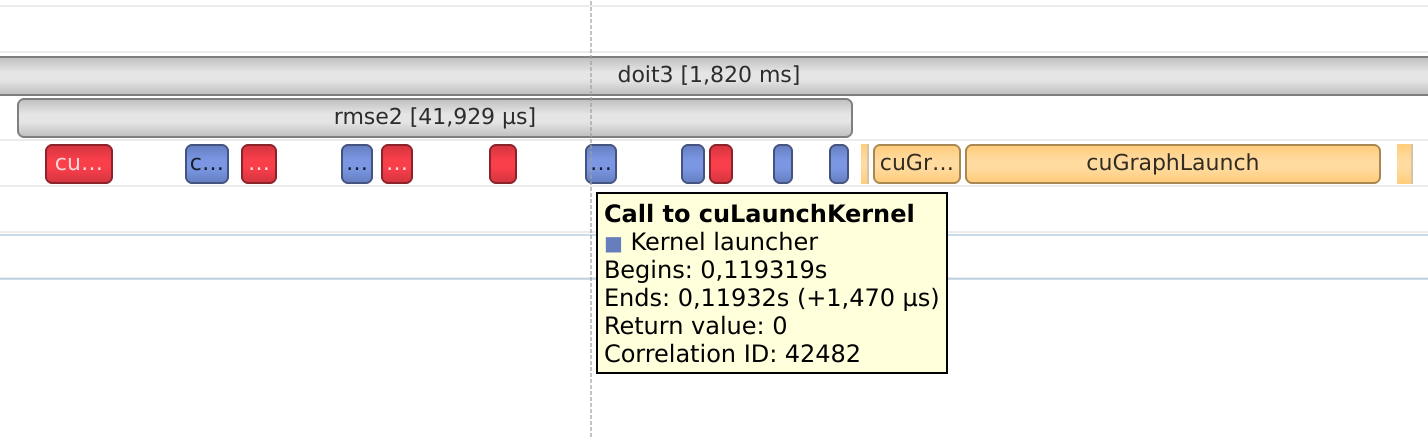

It is of note that although the final performance did not improve, individual API calls now execute much faster, so depending on the application characteristics this may lead to a performance improvement.

The graph launch itself is also much faster than the original iteration, so if you don't need to re-record (which we do now to update the inputs to the graph) this can further speed up evaluation.

Bottom line though, the graph APIs are no silver bullet, and although they can greatly reduce launch overhead they are currently tricky to use (need to avoid unsupported operations) and may not improve performance.